# Online support vector classification with kernels
Each new datapoint may enter or leave the *support vector set*. That makes the QP evolve over time.


### Problem setup

We consider binary classification with data arriving sequentially:

* At round $t$, receive $(x_t, y_t)$, with $x_t \in \mathbb{R}^d$, $y_t \in \{-1,1\}$.
* Maintain a kernel SVM model with active support vectors $S_t$.
* Solve the dual SVM problem on $S_t$:

$$
\begin{aligned}
\max_{\alpha \in \mathbb{R}^{|S_t|}} \;& \sum_{i=1}^{|S_t|} \alpha_i - \tfrac{1}{2} \sum_{i,j=1}^{|S_t|} \alpha_i \alpha_j y_i y_j K(x_i, x_j) \\
\text{s.t. } & 0 \le \alpha_i \le C,\;\; \sum_{i=1}^{|S_t|} \alpha_i y_i = 0.
\end{aligned}
$$

This is a **quadratic program** with:

* Quadratic objective in $\alpha$.
* Linear equality constraint (label balance).
* Box constraints on $\alpha$.

As new points arrive:

* If the margin condition is violated, add $x_t$ to $S_t$.
* If budget exceeded, remove a support vector (budgeted SVM).
  Thus the dimension of the QP and the constraint set change online.

### Key properties for us

* Each new data point can change the set of decision variables ($\alpha$) and constraints.
* The QP has the same structure but varying size.
* Real-time requirement: in practice, online kernel SVMs need fast repeated QP solves.

In [59]:
import numpy as np
import cvxpy as cp
import matplotlib as plt

# Gaussian kernel
def rbf_kernel(X, Y=None, gamma=1.0):
    if Y is None:
        Y = X
    X_norm = np.sum(X**2, axis=1)[:, None]
    Y_norm = np.sum(Y**2, axis=1)[None, :]
    K = np.exp(-gamma * (X_norm + Y_norm - 2 * X @ Y.T))
    return K

def solve_svm_dual(X, y, C=1.0, gamma=1.0):
    n = X.shape[0]
    K = rbf_kernel(X, gamma=gamma)
    # QP variables
    alpha = cp.Variable(n)
    # Dual objective
    obj = cp.Maximize(cp.sum(alpha) - 0.5 * cp.quad_form(cp.multiply(y, alpha), K))
    # Constraints
    constraints = [alpha >= 0, alpha <= C, cp.sum(cp.multiply(alpha, y)) == 0]
    prob = cp.Problem(obj, constraints)
    prob.solve(solver="OSQP", verbose=False)
    return alpha.value

# Simulated online process
np.random.seed(0)
X = np.random.randn(20, 2)
y = np.random.choice([-1, 1], size=20)

support_set = []
budget = 10
C = 1.0
gamma = 0.5

for t in range(len(y)):
    support_set.append(t)
    if len(support_set) > budget:
        # Simple budget policy: drop oldest
        #support_set.pop(0)
        # Remove the one least contributing to the margin
        alphas = solve_svm_dual(X[support_set], y[support_set], C=C, gamma=gamma)
        min_alpha_idx = np.argmin(alphas)
        support_set.pop(min_alpha_idx)
        print()
    Xs, ys = X[support_set], y[support_set]
    #print(Xs)
    alpha = solve_svm_dual(Xs, ys, C=C, gamma=gamma)
#print(f"t={t}, support size={len(support_set)}, alphas={alpha}") #[:3]

[[ 1.86755799 -0.97727788]
 [-0.10321885  0.4105985 ]
 [ 0.76103773  0.12167502]
 [ 0.44386323  0.33367433]
 [ 1.49407907 -0.20515826]
 [ 0.3130677  -0.85409574]
 [ 0.8644362  -0.74216502]
 [ 1.53277921  1.46935877]
 [-0.34791215  0.15634897]
 [ 1.23029068  1.20237985]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


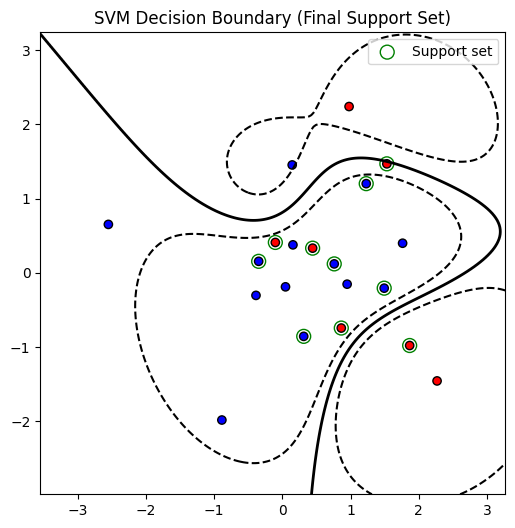

In [60]:
import matplotlib.pyplot as plt


# Decision function
def decision_function(X_test, Xs, ys, alpha, gamma):
    K = rbf_kernel(X_test, Xs, gamma=gamma)
    return (alpha * ys) @ K.T

# Grid for plotting
xx, yy = np.meshgrid(np.linspace(X[:,0].min()-1, X[:,0].max()+1, 200),
                     np.linspace(X[:,1].min()-1, X[:,1].max()+1, 200))
X_grid = np.c_[xx.ravel(), yy.ravel()]
Z = decision_function(X_grid, Xs, ys, alpha, gamma).reshape(xx.shape)

print(Xs)
print(alpha)
# Plot
plt.figure(figsize=(6,6))
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="k")   # decision boundary
plt.contour(xx, yy, Z, levels=[-0.1, 0.1], linestyles="--", colors="k")  # margins
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.bwr, edgecolors="k")
plt.scatter(Xs[:,0], Xs[:,1], s=100, facecolors="none", edgecolors="g", label="Support set")
plt.legend()
plt.title("SVM Decision Boundary (Final Support Set)")
plt.show()

3
0
10
8
0
8
10
9
2
10
[[ 1.86755799 -0.97727788]
 [-0.10321885  0.4105985 ]
 [ 0.76103773  0.12167502]
 [ 0.44386323  0.33367433]
 [ 1.49407907 -0.20515826]
 [ 0.3130677  -0.85409574]
 [ 0.8644362  -0.74216502]
 [ 1.53277921  1.46935877]
 [-0.34791215  0.15634897]
 [ 1.23029068  1.20237985]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


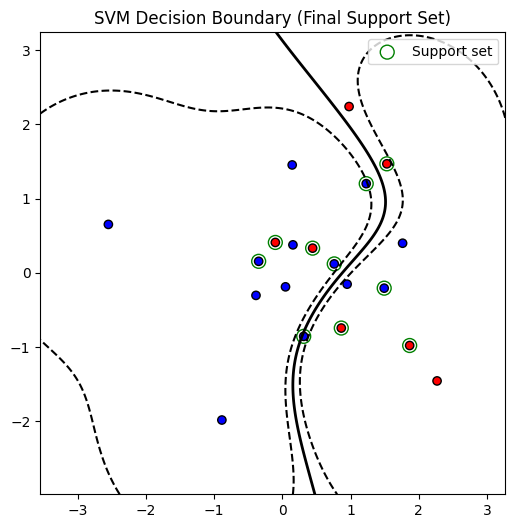

In [58]:
import matplotlib.pyplot as plt
# Simulated online process
np.random.seed(0)
X = np.random.randn(20, 2)
y = np.random.choice([-1, 1], size=20)

support_set = []
budget = 10
C = 1.0
gamma = 0.5

for t in range(len(y)):
    support_set.append(t)
    if len(support_set) > budget:
        # Simple budget policy: drop oldest
        # support_set.pop(0)
        # Remove the one least contributing to the margin
        alphas = solve_svm_dual(X[support_set], y[support_set], C=C, gamma=gamma)
        min_alpha_idx = np.argmin(alphas)
        print(min_alpha_idx)
        support_set.pop(min_alpha_idx)

    Xs, ys = X[support_set], y[support_set]
    #print(Xs)
    alpha = solve_svm_dual(Xs, ys, C=C, gamma=gamma)
    #print(f"t={t}, support size={len(support_set)}, alphas={alpha}") #[:3]

print(Xs)
print(alpha)
# Plot
plt.figure(figsize=(6,6))
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="k")   # decision boundary
plt.contour(xx, yy, Z, levels=[-0.1, 0.1], linestyles="--", colors="k")  # margins
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.bwr, edgecolors="k")
plt.scatter(Xs[:,0], Xs[:,1], s=100, facecolors="none", edgecolors="g", label="Support set")
plt.legend()
plt.title("SVM Decision Boundary (Final Support Set)")
plt.show()

In [ ]:
## model QP here as graph

# one node per variable
# one node per constraint
# how to handle equality constraints?
